# PMT single photon test & baseline test

- test baseline with 0.6V, 1.2V, 1.8V, 2.4V
- test single photon signal

### Packages & Basic Tools 

In [72]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from scipy.special import factorial
from scipy.optimize import leastsq, curve_fit, basinhopping
import math
from functools import partial
from collections import Counter, defaultdict, namedtuple, OrderedDict
import os

np.set_printoptions(linewidth=1<<64)

# Base LED Voltages:
BASE_VOLT = range(90, 270, 30)
BASE_FILE = {volt: f'../../data/0710/{volt:03d}_850_0710V_raw_b0_seg0.bin' for volt in BASE_VOLT}
SIG_VOLT = list(range(252, 260, 2)) + list(range(260, 268, 1))
SIG_FILE = {volt: f'../../data/0710/{volt:03d}_850_0710V_raw_b0_seg0.bin' for volt in SIG_VOLT}
VOLT_SCALE = 2000 / (1 << 14)   # FLASH ADC UNIT -> mV
TIME_SCALE = 4                  # FLASH ADC UNIT -> ns
FLASH_ADC_R = 50                # FLASH ADC INNER RESISTOR
E_UNIT = 1.6E-1                 # 1M e -> mV * ns / Ohm
AREA_SCALE = VOLT_SCALE * TIME_SCALE / (FLASH_ADC_R *E_UNIT)

TXT_PATH = '0710/out/'
PLOT_PATH = '0710/fig/'
os.makedirs(TXT_PATH, exist_ok=True)
os.makedirs(PLOT_PATH, exist_ok=True)
STD_FILE = lambda ch, volt: f"ch{ch}-{volt:03d}.txt"


def get_int(data: bytes, bit: int=None, byteorder: str='little') -> int:
    """
        Return given bits from binary `bytes`.

        Example
        -------
        ```
        >>> data = b'\\x10\\x0a'   
                    # from little: 00001010 00010000
                    # from big:    00001000 00001010
        >>> int_from_bytes(data, 10, byteorder = 'little')  
        528             # 0b1000010000 == 528
        >>> int_from_bytes(data, 10, byteorder = 'big')     
        10              # 0b0000001010 == 10
        ```
    """
    bit = bit or len(data) << 8
    return int.from_bytes(bytes=data, byteorder=byteorder) & ((1 << bit + 1) - 1)


def nzero_bit(data: int) :
    """
        Return a Generator of all non-zero bit.
    
        Example
        --------
        ```python
        >>> data = 19  # 0b10011
        >>> list(nzero_bit(data))
        [0, 1, 4] 
        ```
    """
    return (ch for ch in range(data.bit_length()) if data & (1 << ch))


def decode_file(file: str, ev=range(0, 1<<60), ch=range(0,64)):
    """
    decode file and yield channel data in each loop.

        Args
            file: name of the file that will be decoded.
            ev: event range of all channel. 
            ch: channel list.
    
        `yield (channel_id, channel_event_id, signal_list)`
    """
    ch_count = Counter()
    ch_gen_count = Counter()
    with open(file , mode='rb') as f:
        ## Read All Event
        while (True):
            ## Reader header for a single event
            ev_header = f.read(4 << 2)
            ## Check if file pointer reaches EOF or generated
            if len(ev_header) == 0 or sum(ch_gen_count.values()) >= len(ev) * len(ch):
                break
            ## Get Channel Mask
            ev_ch_mask = ev_header[4] + (ev_header[11] << 8)
            ev_ch = nzero_bit(ev_ch_mask)
            for ch_id in ev_ch:
                ## Read header for all Channel
                ch_header = f.read(3 << 2)
                ## Get Channel Size
                ch_size = get_int(ch_header[:3], 22) 
                sig_size = (ch_size - 3) << 2
                ## Count ++
                ch_count[ch_id] += 1
                if (ch_count[ch_id] - 1 in ev) and (ch_id in ch):
                    ## Get Channel Raw Signal and Process
                    raw_sig = f.read(sig_size)      # binary signal list
                    sig = np.frombuffer(raw_sig, dtype=np.int16).astype(int)
                    ## yeild channel data
                    ch_gen_count[ch_id] += 1
                    yield ch_id, ch_count[ch_id] - 1, sig
                else:
                    f.seek(sig_size, 1)

def update_file(file: str, data: dict[str, str]):
    """
    update data file from given `data` dict
    """

    with open(file, 'a') as nf:
        with open(file, 'r') as f:
            data_line = f.readlines()
            for count, content in enumerate(data_line):
                if (key := content[:50].strip()) in data:
                    data_line[count + 1] = f"{data[key]}\n"
                    data.pop(key)
        nf.seek(0)
        nf.truncate()
        nf.writelines(data_line)

        new_data = [f'{data_key}\n{value}\n' for data_key, value in data.items()]
        nf.writelines(new_data)

def load_file(file: str, data_type: dict, rm_char=None):
    """
    load specific data from given file.
    """
    out = {}
    with open(file) as f:
        while line := f.readline():
            if (key := line[:50].strip()) in data_type:
                out[key] = data_type[key](f.readline().strip(rm_char))
    return out




### Plot Single signal 

In [5]:
def plot_signal(file: str, ev=range(0, 3), ch=range(16), **kw):
    """
    Plot single signal.
    
        Args:
            file (str):
                data source
            ev (Iterable):
                event range (default `range(0,10)`)
            ch (Iterable):
                channel range (default `range(0,16)`)
            kw:
                keyword args passed to `plt.plot()`
    """
    for ch, ev_id, sig in decode_file(file, ev=ev, ch=ch):
        # print(ev_id, ch)
        plt.plot(sig, **kw)
        plt.title(f'channel {ch} id {ev_id}')
        plt.xlabel('sample / Flash ADC Time Unit')
        plt.ylabel('Voltage / Flash ADC Voltage Unit')
        plt.grid()
        plt.show()

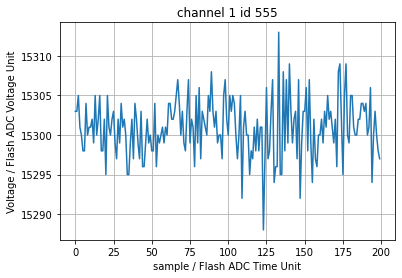

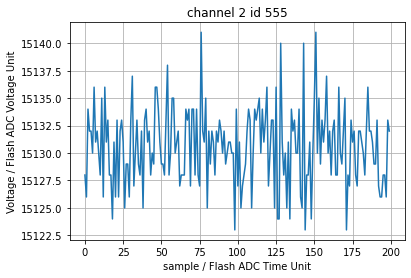

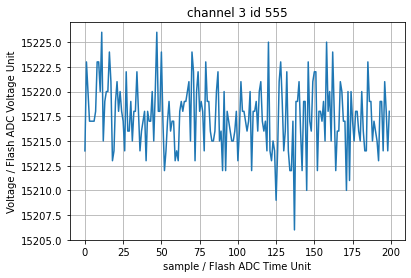

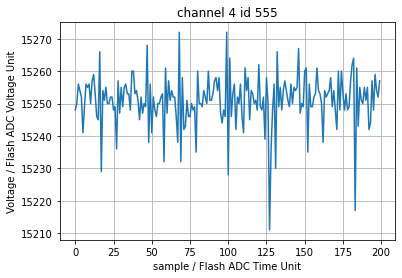

In [11]:
# Plot single signal
plot_signal(f"../../data/0710/258_850_0710V_raw_b0_seg0.bin", ev=(555,), ch=(1,2,3,4))

### Get Average Signal & Base Analysis

##### Get average signal and base from raw file

In [73]:
def avg_fromraw(file: str, ch = range(0, 16)) -> defaultdict[int, dict]:
    """
    Get average signal or average squared signal from file

        Return:
            A dict whose:
                keys: channel id
                values: a dict that contains :
                    `sig`: average signal 
                    `sigsq`: square average signal  
                    `count`: event count
    """
    data = defaultdict(lambda: {'sig': 0, 'sigsq':0, 'count': 0})

    for ch, ev, sig in decode_file(file):
        data[ch]['sig'] +=  sig
        data[ch]['sigsq'] += sig ** 2
        data[ch]['count'] = ev + 1
    for val in data.values():
        val['sig'] = val['sig'] / val['count']
        val['sigsq'] = val['sigsq'] / val['count']
    return data


## Get average signal from file
# avg_sig: dict = {ch: {volt: {sig_list, sq_sig_list, count}, ...}, ...}

def avg_sig_volt(sig_file: dict[int, str], save: False) -> defaultdict[int, dict[int, dict]]:
    avg_info = defaultdict(dict)

    for volt, file in tqdm(sig_file.items()):
        this_avg = avg_fromraw(file)
    
        for ch, avg_data in this_avg.items():
            avg_info[ch][volt] = avg_data
            if save:
                update_file(TXT_PATH + STD_FILE(ch, volt), avg_data)

    return avg_info

In [38]:
# read 
avg_base = avg_sig_volt(BASE_FILE, True)
avg_sig = avg_sig_volt(SIG_FILE, True)

100%|██████████| 12/12 [01:30<00:00,  7.51s/it]


##### Read file

In [68]:
def avg_loadfile(volt_range):
    avg_data = defaultdict(dict)
    for ch in (1,2,3,4):
        for volt in volt_range:
            path = TXT_PATH + STD_FILE(ch, volt)
            type_dict = {
                'sig':   lambda _: np.fromstring(_ , sep=' '), 
                'sigsq': lambda _: np.fromstring(_ , sep=' '), 
                'count': int
                }
            avg_data[ch][volt] = load_file(path, type_dict, rm_char='[]\n')
    return avg_data

avg_base = avg_loadfile(BASE_VOLT)
avg_sig = avg_loadfile(SIG_VOLT)

##### Plot average signal

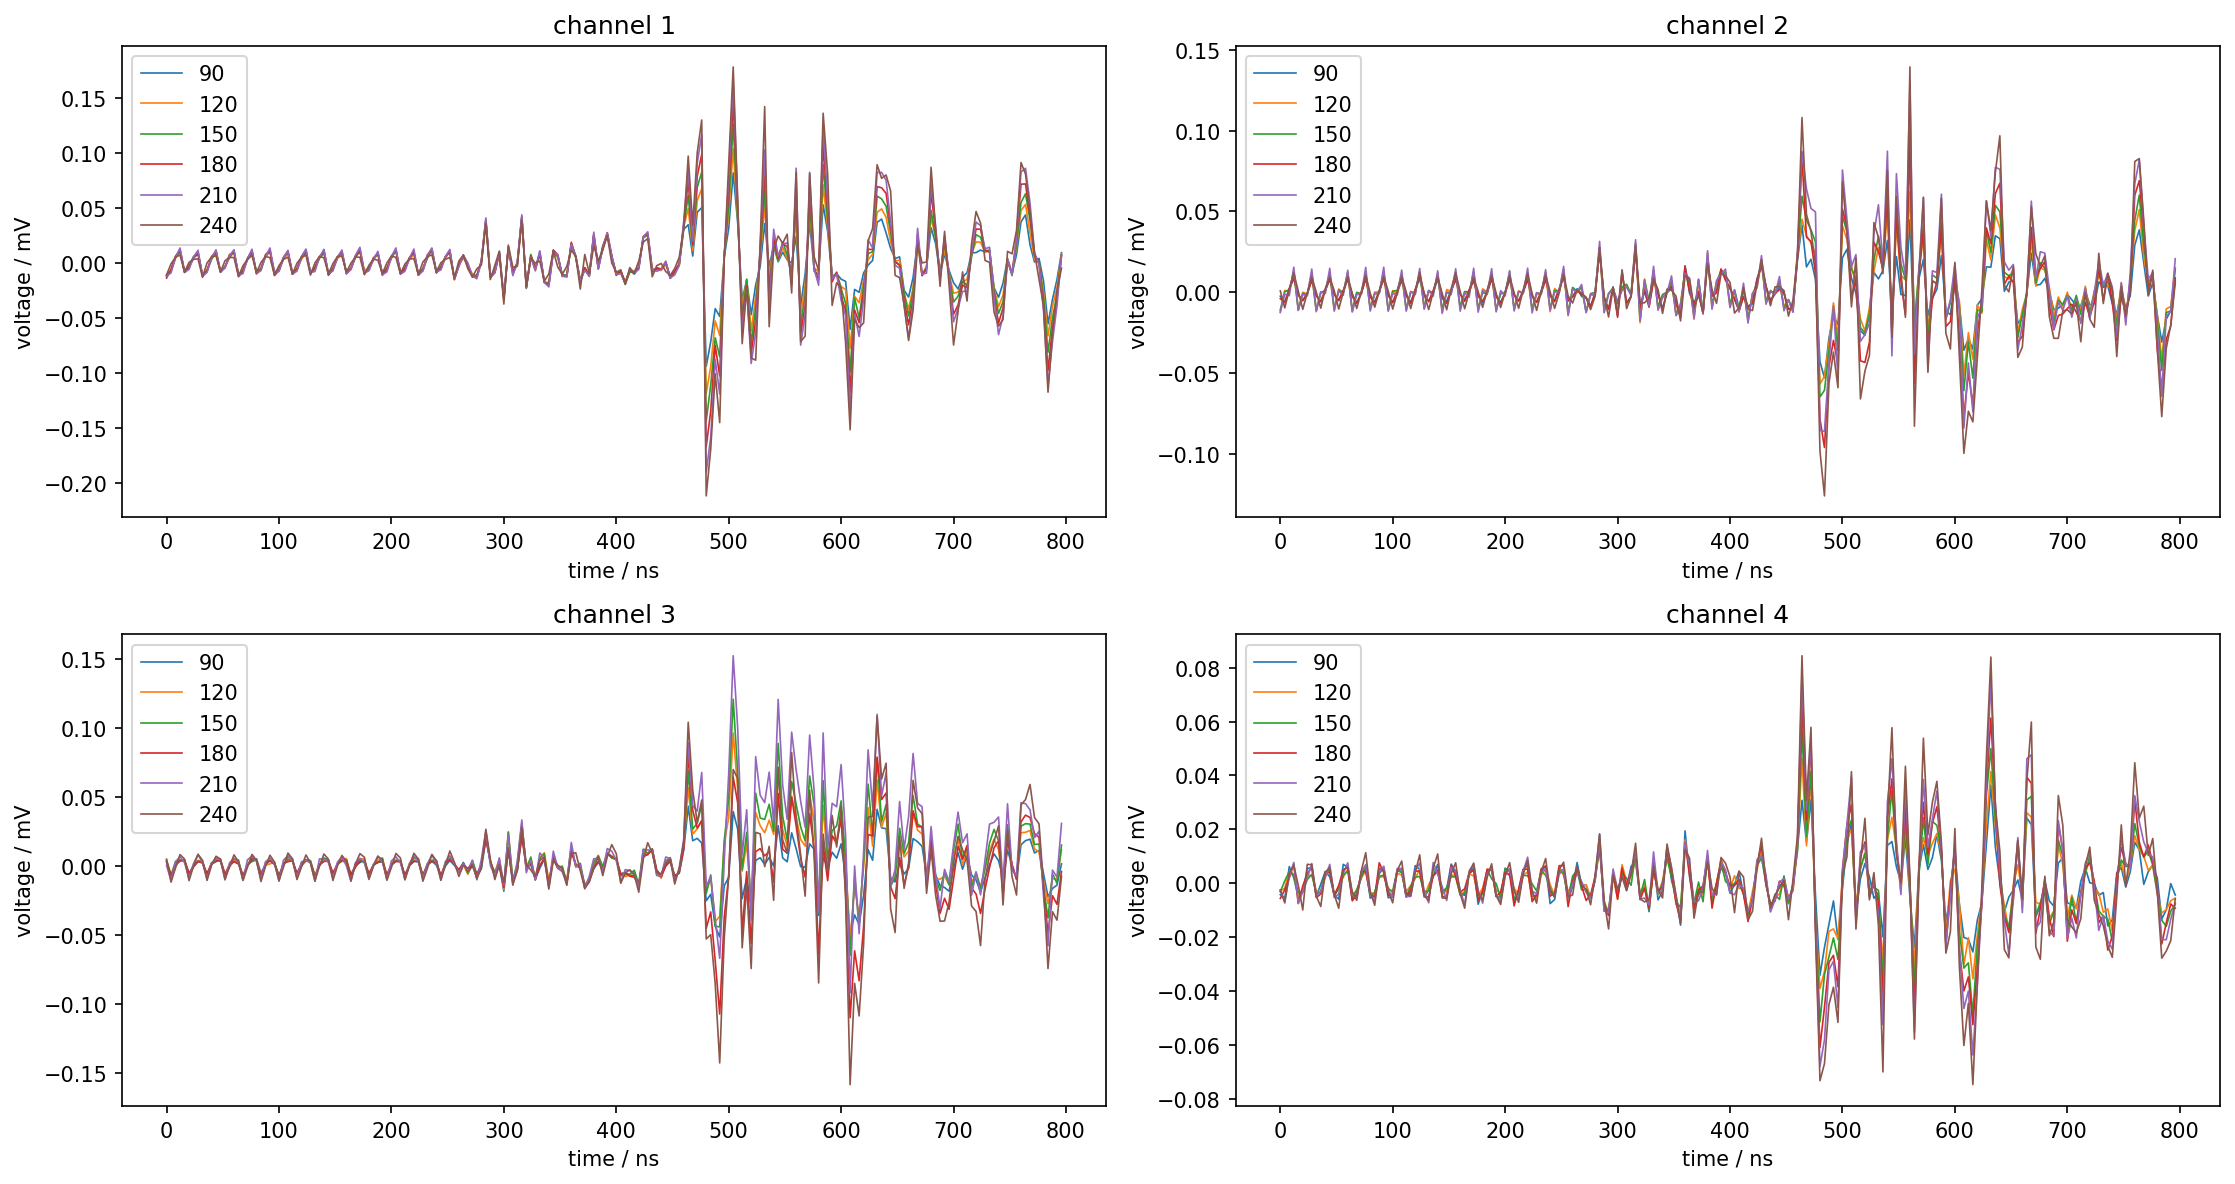

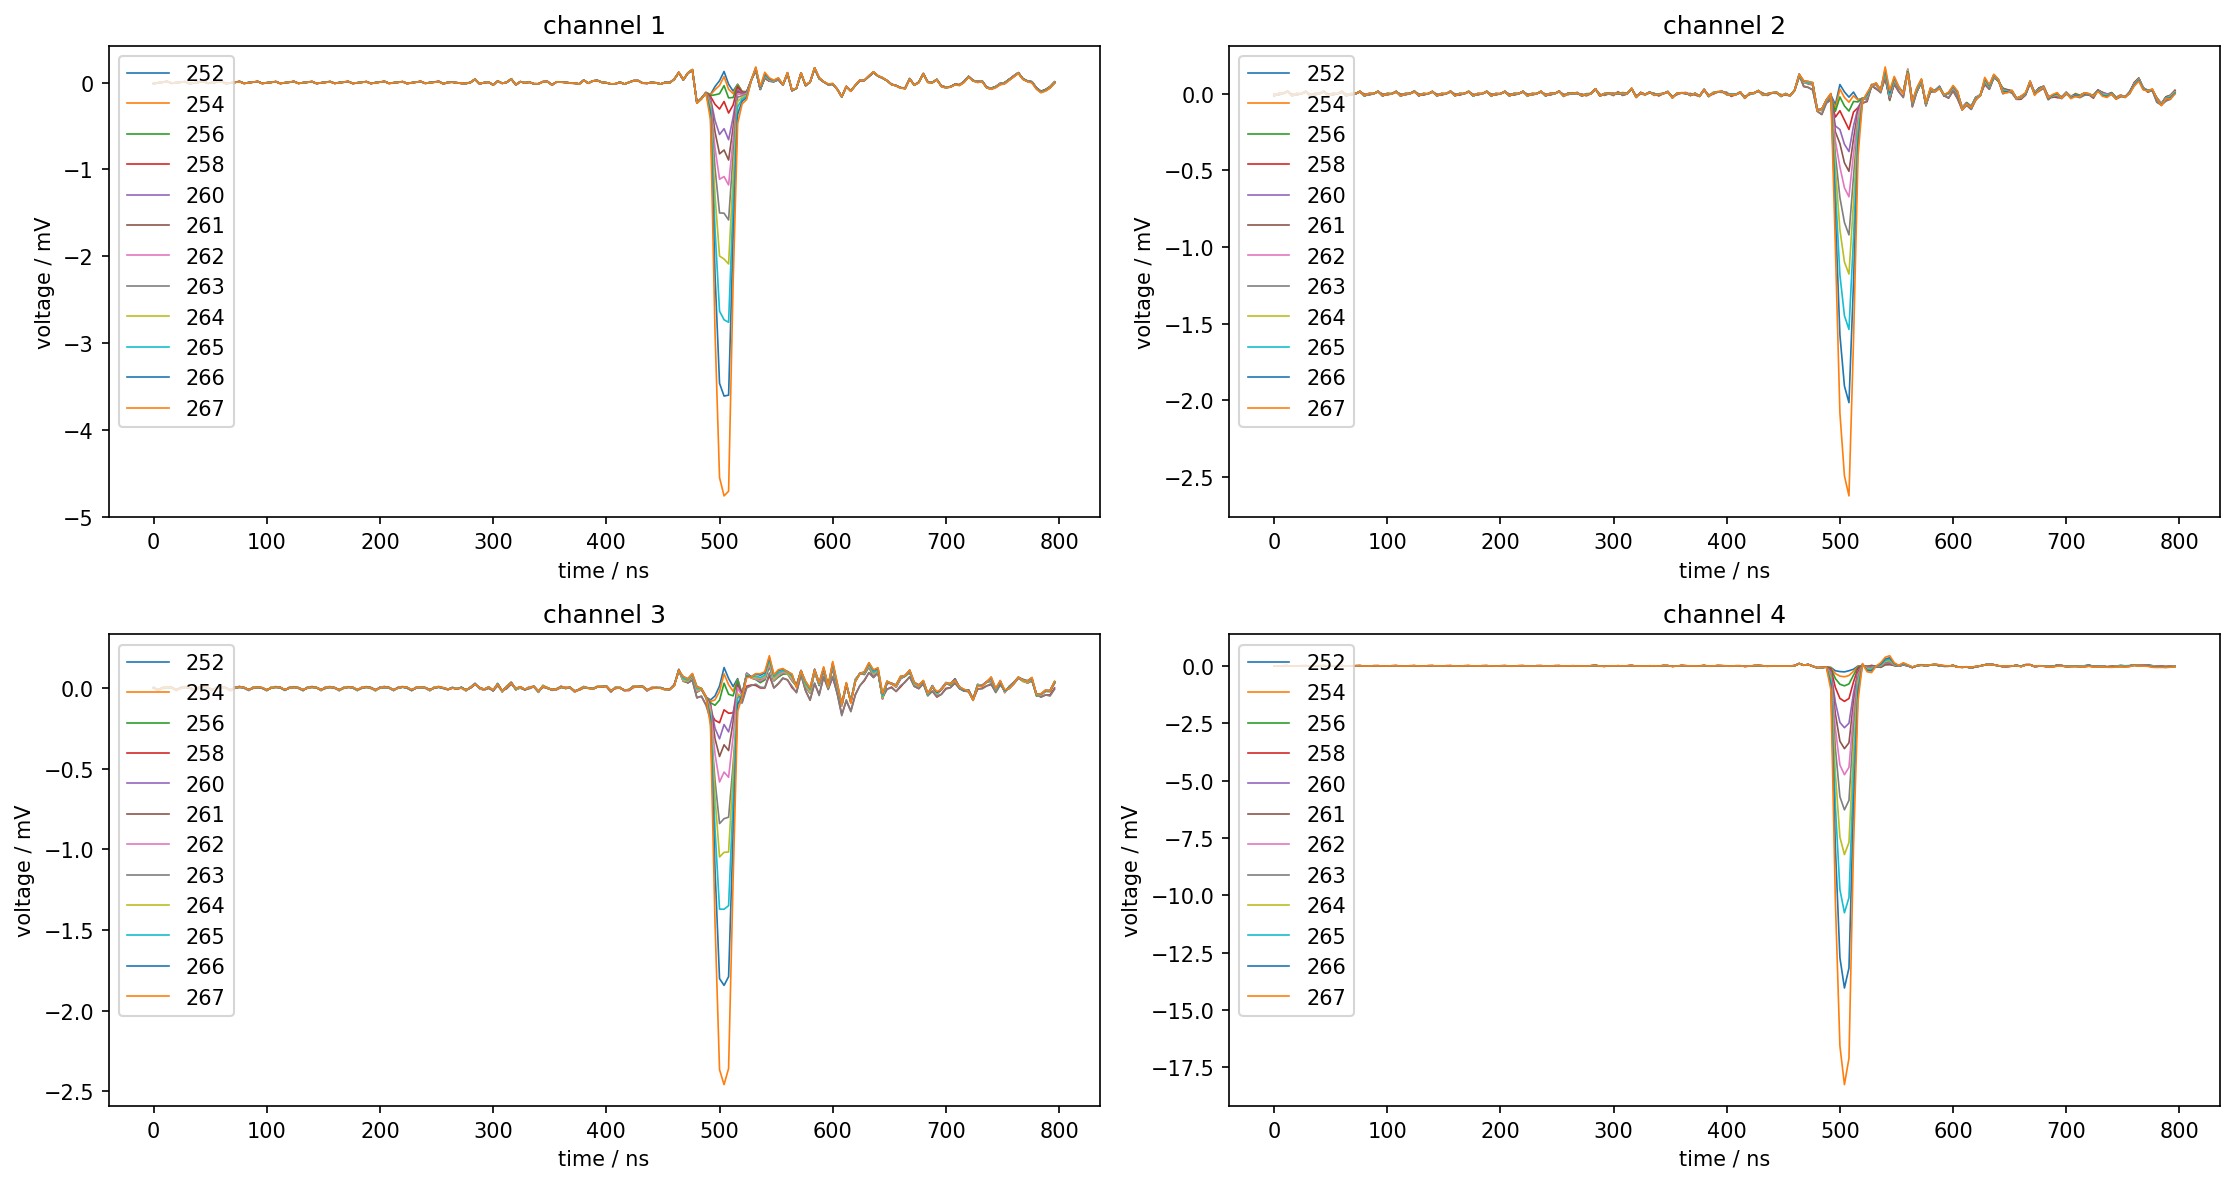

In [76]:
def plot_avg(avg_info, filename: None):
    '''
    plot average signal
    '''
    fig, axes = plt.subplots(2,2, figsize=(15,8), dpi=150)
    for ch, vdata in avg_info.items() :
        legend = []
        chid = ch - 1
        ax = axes[chid // 2 ][chid % 2]
        for v, data in vdata.items():
            legend.append(v)
            sig = data['sig'] * VOLT_SCALE
            ax.plot(np.arange(len(sig)) * TIME_SCALE, ( sig- np.average(sig[:50])), linewidth=.8)
        ax.legend(legend,loc='upper left')
        ax.set_title(f'channel {ch}')
        ax.set_xlabel('time / ns')
        ax.set_ylabel('voltage / mV')
    plt.tight_layout()
    if filename is not None:
        plt.savefig(f"{PLOT_PATH}{filename}.png", dpi=300)
    plt.show()

plot_avg(avg_base, "avg_base")
plot_avg(avg_sig, "avg_signal")

##### Linear Fit

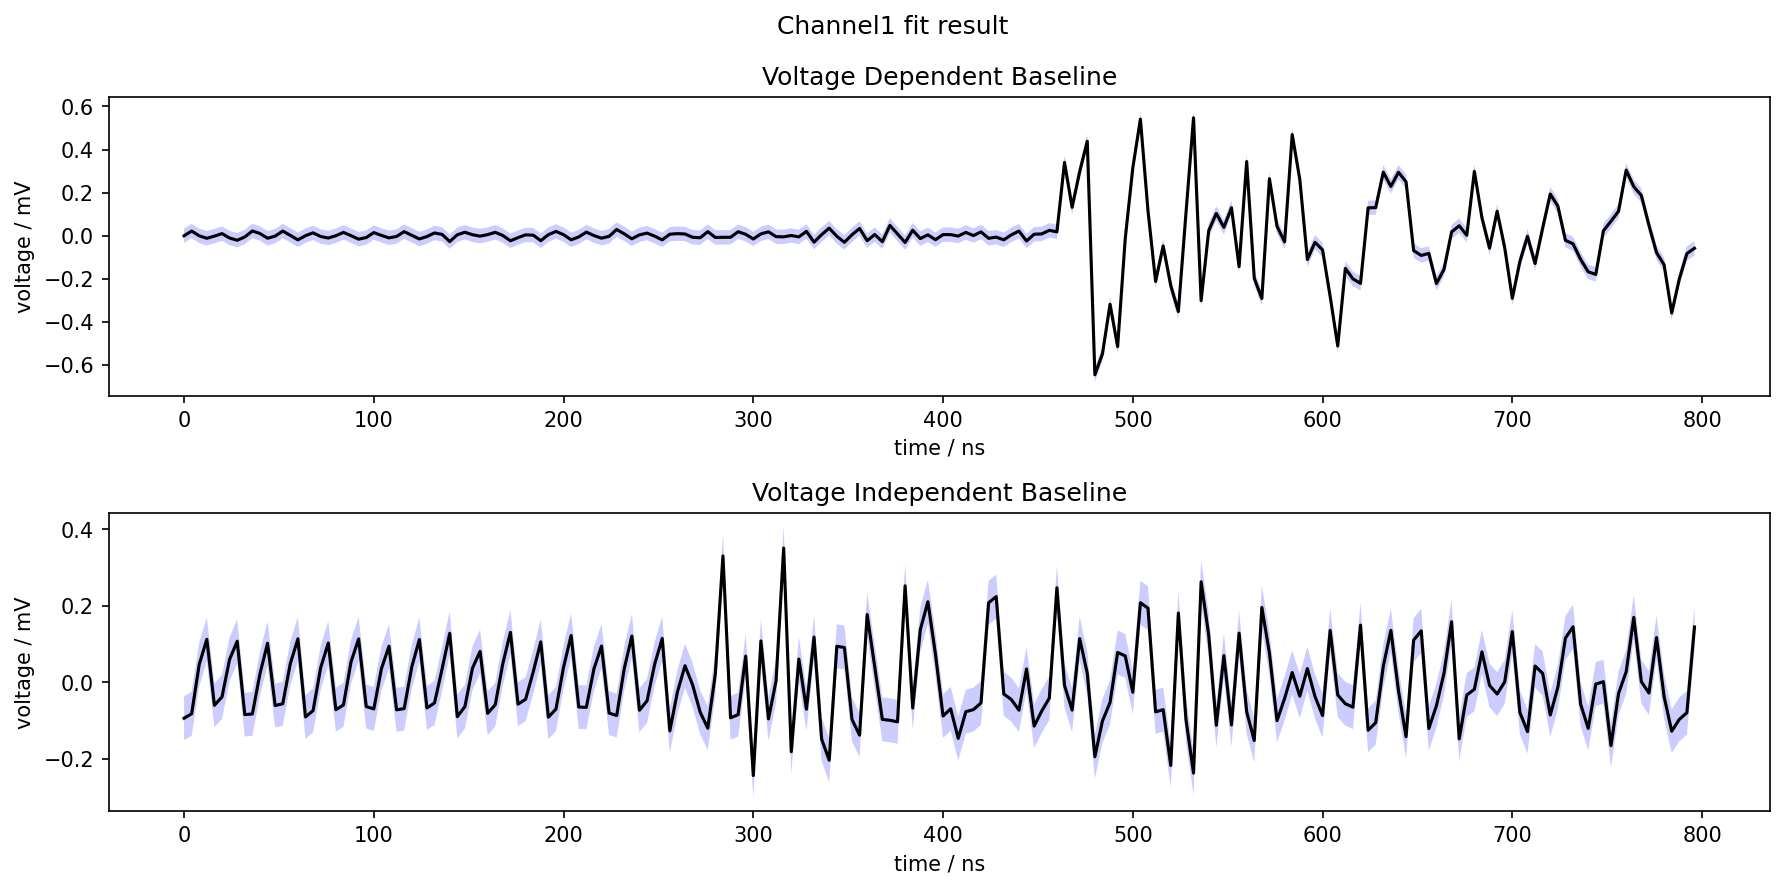

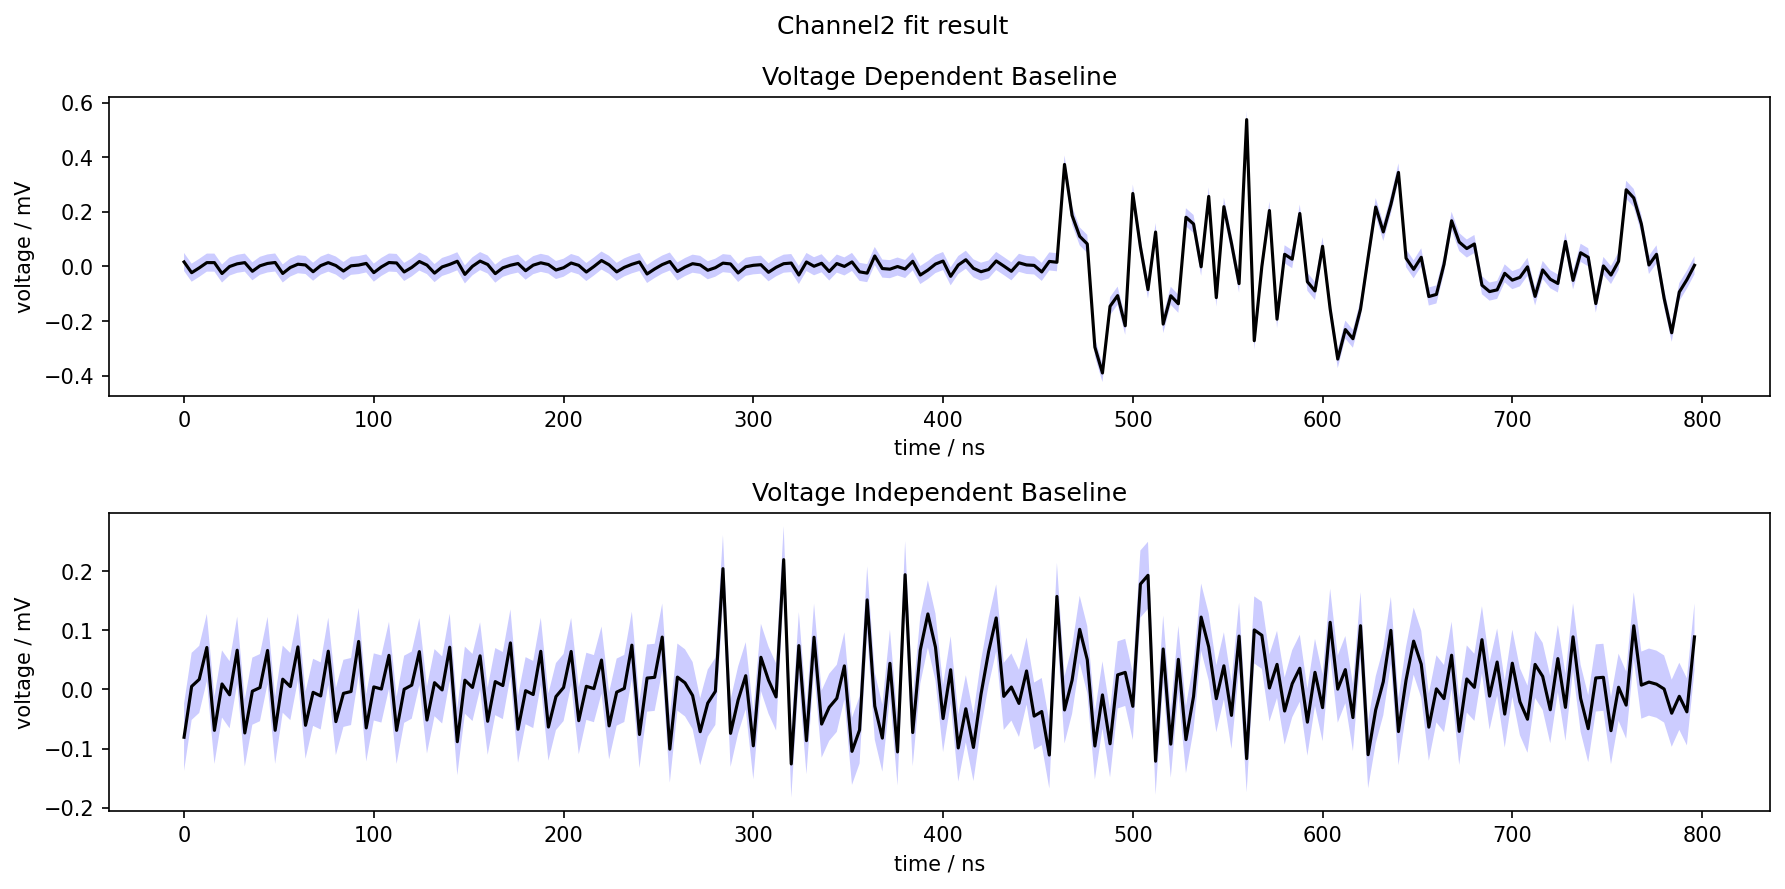

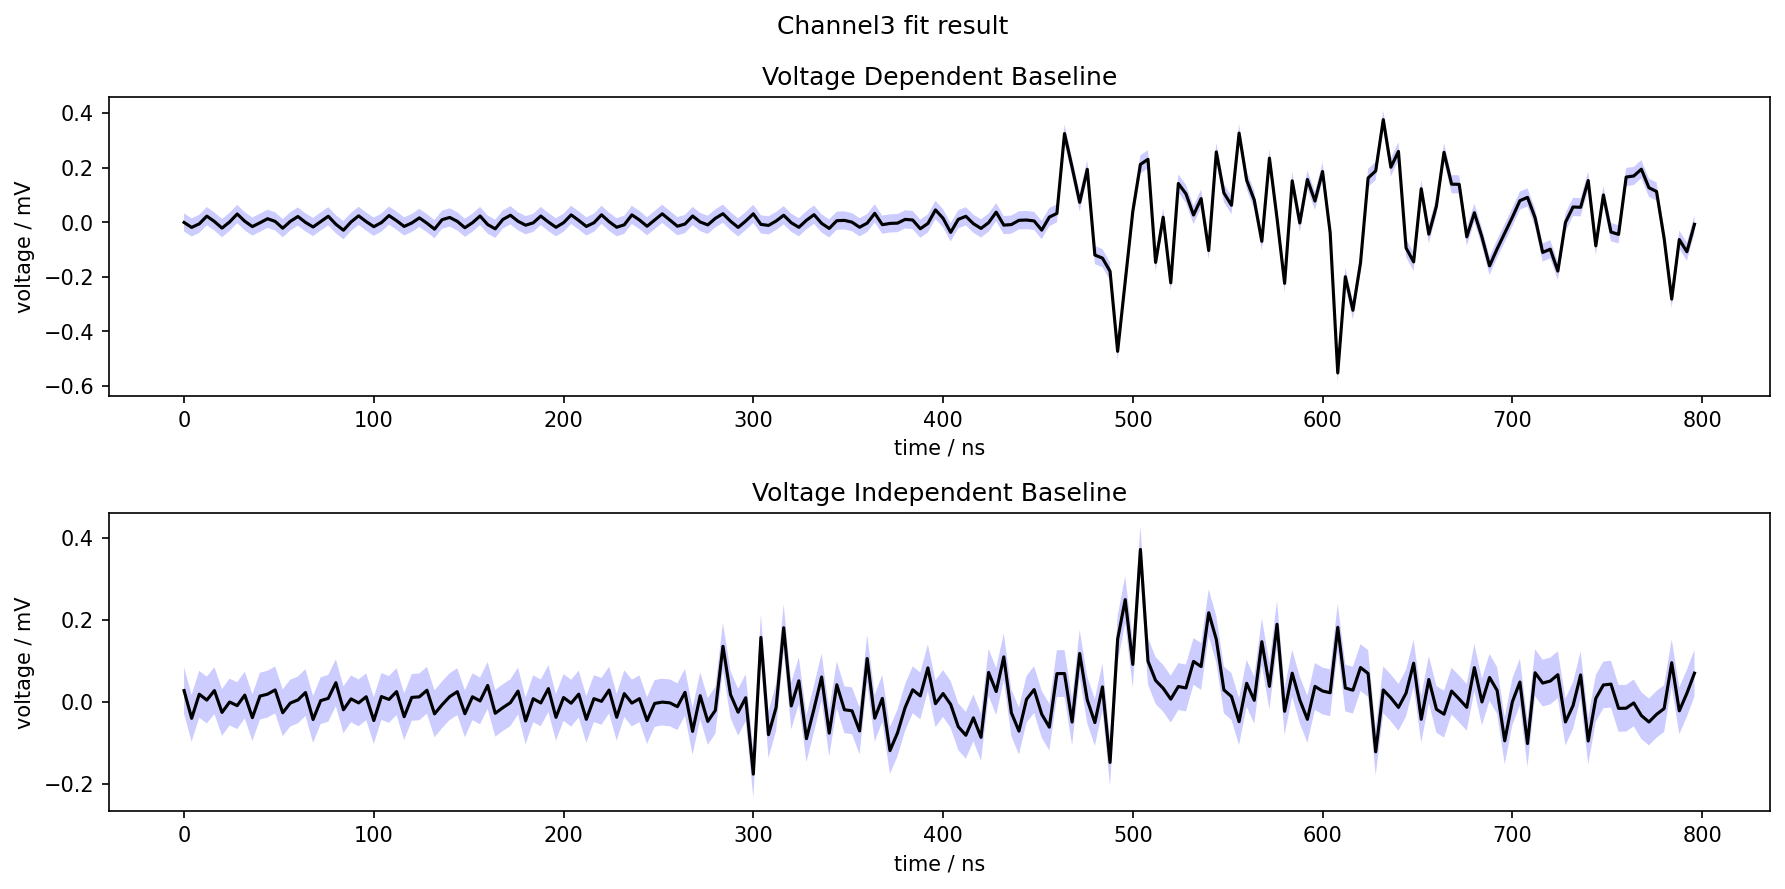

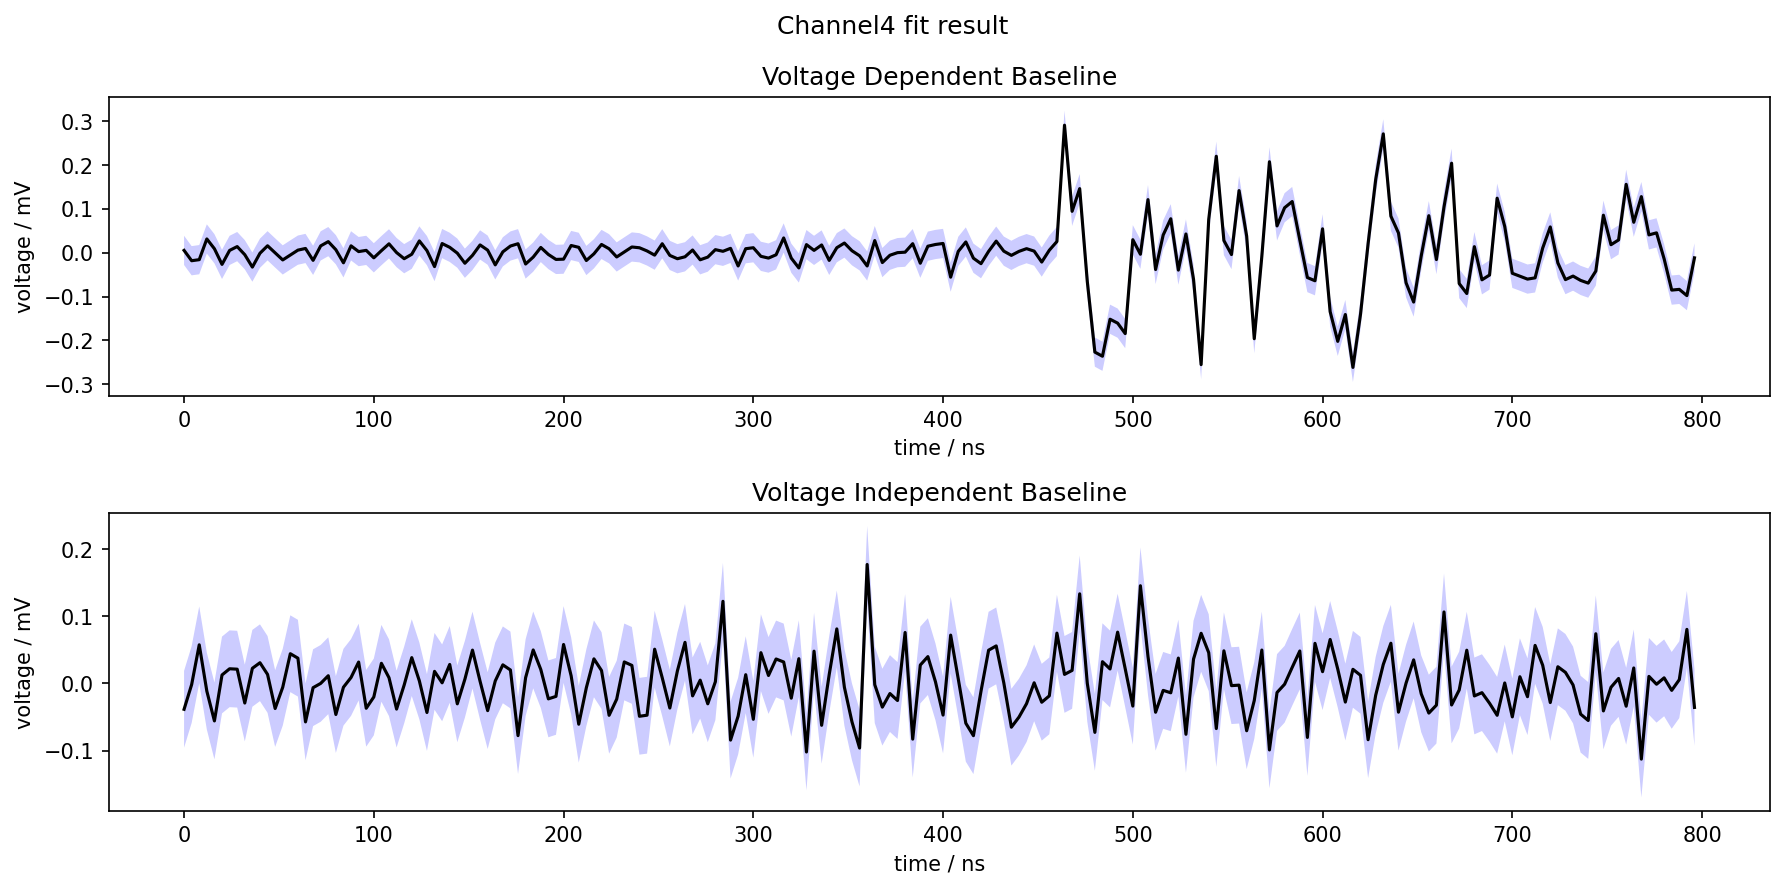

In [82]:
# leastsq linear fit formula
# linear fit `y = a x + b`
def linear_fit (x, y, weight, rss=None):
    n = np.sum(weight)
    Avgx = np.sum(x*weight) / n
    Avgy = np.sum(y*weight) / n
    Sxx = np.sum(weight*x**2) - n*Avgx**2
    Sxy = np.sum(weight*x*y) - n*Avgx*Avgy
    b1 = Sxy / Sxx
    b0 = Avgy - b1*Avgx
    if rss is None:
        return b1, b0 
    else:
        Vary = (np.sum(rss) + np.sum((y - Avgy) ** 2)) / n
        Stdb1 = math.sqrt(Vary / Sxx)
        Stdb0 = math.sqrt(Vary * (1/n + Avgx**2/Sxx))
        return b1, b0, Stdb1, Stdb0

# Fit Data
fit_res = defaultdict(list)
for ch, vdata in avg_base.items():
    volt = np.array([*vdata]) / 100
    # unpack from data
    sig, sigsq, count = zip(*[d.values() for d in vdata.values()])
    sig, sigsq = np.array(sig), np.array(sigsq)
    # align data and cut
    sigT, sigsqT = (sig - np.average(sig[:, :50], axis=1)[:, None]).T, sigsq.T
    rssT = sigsqT - sigT ** 2

    for i in range(len(sigT)):
        this_fit = linear_fit(x=volt, y=sigT[i], rss=rssT[i], weight=count)
        fit_res[ch].append(this_fit)

    fit_res[ch] = np.array(fit_res[ch]).T

# Plot
for ch, (b1, b0, s1, s0) in fit_res.items():
    fig, (dv, iv) = plt.subplots(2,1, figsize=(12,6), dpi=150)
    fig.suptitle(f'Channel{ch} fit result')
    x = np.arange(len(b1)) * TIME_SCALE

    def subplt(ax, x, y, err, title):
        ax.plot(x, y, c='0')
        ax.fill_between(x, y-err, y+err, facecolor='#ccf', edgecolor='none')
        ax.set_title(title)
        ax.set_xlabel('time / ns')
        ax.set_ylabel('voltage / mV')

    subplt(dv, x, b1, s1, 'Voltage Dependent Baseline')
    subplt(iv, x, b0, s0, 'Voltage Independent Baseline')
    
    plt.tight_layout()
    plt.savefig(PLOT_PATH + f'ch{ch}_fit.png', dpi=300)
    plt.show()

### Analyse e count and peak value distribution

##### Decode file

In [82]:
class Config:
    ## Default settings
    _max_voltage = 2000
    _y_resolution = 16384
    _default_scale = _max_voltage * 4 *10 / (_y_resolution * 50 * 1.6) # area (1*1) ~ electron count (1e6)
    ## signal range
    _signal_start = 0
    _signal_end = 200
    ## Peak range = (peak_index - before, peak_index + after)
    _event_start = 121  # 10 
    _event_end  = 133  # 10 
    ## Baseline config
    _use_base = 0               # 4 for all base, 0 for base before sig, 2 for base after sig. default 0
    _calc_all_base = False      # If `False`, only calculate base1
    _fitted_baseline = False
    # _interval = 3             # interval between baseline bounds and event bounds
    _base_cut_front = 50
    _base_cut_back = 140
    ### Advanced Setting
    _find_avg_peak = False
    _calc_base_std = False # TODO: set it!


class CH_Data(Config):
    def __init__ (self, chn: int):
        super(CH_Data, self).__init__()
        self.chn=chn  
        self.base_info = []      # list[tuple] : (base1_avg, base1_std, base2_avg, base2_std, base_avg, base_std)
        self.event_area = []     # event area of all events
        self.peak_value = []
        self.peak_index = []     # Temp!!!
        self.dist = {}
        self.peak_dist = {}
        self.event_count = 0

    def update(self, sig: bytes, base: np.ndarray=0):
        sig = sig * VOLT_SCALE
        if self._fitted_baseline:
            sig -= base
        ## Analyse baseline
        ### baseline before event
        #### FIXME: np.std(x) -> np.sqrt(np.sum(x**2) / len(x) - np.average(x) ** 2)
        base1 = sig[self._signal_start:self._base_cut_front]
        base1_avg = np.sum(base1) / len(base1)
        base1_std = np.std(base1)  if self._calc_base_std else -1
        if self._calc_all_base:
            ### baseline after event
            base2 = sig[self._base_cut_back:self._signal_end]
            base2_avg = np.sum(base2) / len(base2)
            base2_std = np.std(base2) if self._calc_base_std else -1
            ### total baseline
            base = np.concatenate((base1, base2))
            base_avg = np.sum(base) / len(base)
            base_std = np.std(base) if self._calc_base_std else -1
        else:
            base2_avg, base2_std, base_avg, base_std = -1, -1, -1, -1           # Maybe `empty` can be better??
        self.base_info.append((base1_avg, base1_std, base2_avg, base2_std, base_avg, base_std))
        ### get event range & area
        event = sig[self._event_start : self._event_end]
        self.event_area.append(np.sum(event) * AREA_SCALE / VOLT_SCALE)
        ## Analyse (Raw) Peak Value 
        self.peak_value.append(np.min(sig))          # FIXME: sig???
        self.peak_index.append(np.argmin(sig))     # FIXME: Temp, get indics
        ## Count ++
        self.event_count += 1

    def get_distribution(self):
        if len(self.event_area) == 0:
            return
        self.dist = Counter()
        self.event_area = np.array(self.event_area)
        base = np.array(self.base_info).T[self._use_base]
        area = base*(self._event_end-self._event_start) * AREA_SCALE / VOLT_SCALE - self.event_area
        area = np.round(area/AREA_SCALE) * AREA_SCALE
        for i in area:
            self.dist[i] += 1

    def get_peak_distribution(self, base = 0):
        if len(self.peak_value) == 0:
            return
        self.peak_dist = Counter()
        peak = zip(self.peak_index, self.peak_value)
        for i in peak:
            self.peak_dist[round((base - i[1]) / VOLT_SCALE) * VOLT_SCALE] += 1
        

    def get_from_file(self,   data_list, mode: str):
        header = np.fromstring(data_list[0], int , sep=',')
        if (len(header) <= 1):
            return
        chn, chn.event_count = header
        if chn != self.chn:
            return
        ## set mode
        if mode == 'raw':
            self.event_area  = np.fromstring(data_list[1], float , sep=',').astype(int)
            self.base_info = np.array([np.fromstring(s, sep=',', dtype=float) for s in data_list[2:]]).T
            self.get_distribution()
        if mode == 'dist':
            x    = np.fromstring(data_list[1], int , sep=',')
            dist = np.fromstring(data_list[2], int , sep=',')
            self.dist = dict(zip(x, dist))
        if mode == 'peak':
            self.peak_value = np.fromstring(data_list[1], float , sep=',')
            self.peak_index = np.fromstring(data_list[2], float , sep=',')
            self.get_peak_distribution()

def dist_from_raw(file:str, base:dict=Counter(), loop=1<<56):
    ch_data = Counter()
    for ch, _, sig in decode_file(file, ev=range(loop)):
        if ch_data[ch] == 0:
            ch_data[ch] = CH_Data(ch)
        ch_data[ch].update(sig, base[ch])
    return ch_data

##### R&W and Plot Tools

In [68]:
def plot(x, y, subplt, title: str, scale: float = 1, fontsize= 5 , xlim= None, ylim=None,  aspect= .8, s=3, marker = 'o'):
    if len(x) == 0:
        return
    x = np.array(x) * scale
    subplt.scatter(x , y , s=s, marker = marker)
    # subplt.plot(x , y , lw = 1)    # FIXME: TEMP
    if xlim:
        subplt.set_xlim(*xlim)
    if ylim:
        subplt.set_ylim(*ylim)
    subplt.set_box_aspect(aspect)
    subplt.set_title(f"{title}",  pad=3)

def plot_ecount(chn: CH_Data, subplt,  title: str, **kwargs):
    x , y = list(chn.dist.keys()), list(chn.dist.values())
    plot(x, y, subplt, title,   **kwargs)
    subplt.set_xlabel('electron count / x10^6 e-',  labelpad=3)
    subplt.set_ylabel('Event count')

def plot_pcount(chn: CH_Data, subplt,  title: str, **kwargs):
    x , y = np.array(sorted(list(chn.peak_dist.items()), key= lambda x : x[0])).T  # FIXME: TEMP
    # x , y = list(chn.peak_dist.keys()), list(chn.peak_dist.values()) # FIXME: TEMP
    plot(x,y,subplt, title,**kwargs)
    # plot(x,y,subplt, title, scale = chn._max_voltage / chn._y_resolution, **kwargs)
    subplt.set_xlabel('peak value ',  labelpad=3)
    subplt.set_ylabel('Event count')

# def plot_idist(chn: CH_Data, subplt,  title: str, **kwargs):
#     x , y = -np.array(chn.peak_value) , chn.peak_index
#     plot(x,y,subplt, title, **kwargs)

# def plot_icount(chn: CH_Data, subplt,  title: str, **kwargs):
#     idist = np.array(sorted(list(chn.peak_idist.items()), key = lambda x : x[0])[75:100]).T
#     x , y = idist
#     plot(x,y,subplt, title)

def save_raw_to_file(chn: CH_Data, file: str):
    if len(chn.event_area) == 0:
        return
    with open(file, "a") as f:
        np.savetxt(f, [[chn.chn, chn.event_count], chn.event_area], delimiter=',', fmt='%d')
        base_info_T = np.array(chn.base_info).T
        np.savetxt(f,base_info_T, fmt='%.4f', delimiter=',')

def save_dist_to_file(chn:CH_Data, file:str):
    if len(chn.dist) == 0:
        if len(chn.event_area) == 0:
            return
        chn.get_distribution()
    with open(file, 'a') as f:
        # header , e count , number
        np.savetxt(f, [[chn.chn, chn.event_count], list(chn.dist.keys()), list(chn.dist.values())] , delimiter=',', fmt='%d')

def save_peak_to_file(chn: CH_Data, file: str):
    if len(chn.peak_value) == 0:
        return
    with open(file, "a") as f:
        # header , peak_value
        np.savetxt(f, [[chn.chn, chn.event_count]], delimiter=',', fmt='%d')
        np.savetxt(f, [chn.peak_value, chn.peak_index], delimiter=',', fmt='%f')


def read_file(file: str, mode: str = 'raw'): # mode in {'raw', 'dist'}
    chn_data = {}
    with open(file, 'r') as f:
        while(True):
            header = np.fromstring(f.readline(), int , sep=',')
            if (len(header) <= 1):
                break
            chn = CH_Data(header[0])
            chn.event_count = header[1]
            if mode == 'raw':
                chn.event_area  = np.fromstring(f.readline(), float , sep=',').astype(int)
                chn.base_info = np.array([np.fromstring(f.readline(), sep=',', dtype=float) for s in range(6)]).T
                chn.get_distribution()
            elif mode == 'dist':
                x    = np.fromstring(f.readline(), int , sep=',')
                dist = np.fromstring(f.readline(), int , sep=',')
                chn.dist = dict(zip(x, dist))
            elif mode == 'peak':
                chn.peak_value = np.fromstring(f.readline(), float , sep=',')
                chn.peak_index = np.fromstring(f.readline(), float , sep=',')
                chn.get_peak_distribution()
            else:
                raise Exception
            chn_data[chn.chn] = chn
    return chn_data


In [76]:
fbaseline = {ch: fit_res[ch][0] * 2.64 + fit_res[ch][1] for ch in (1,2,3,4)}

In [83]:
data =  dist_from_raw(f'../../data/0710/264_850_0710V_raw_b0_seg0.bin', fbaseline)

##### *TEST*

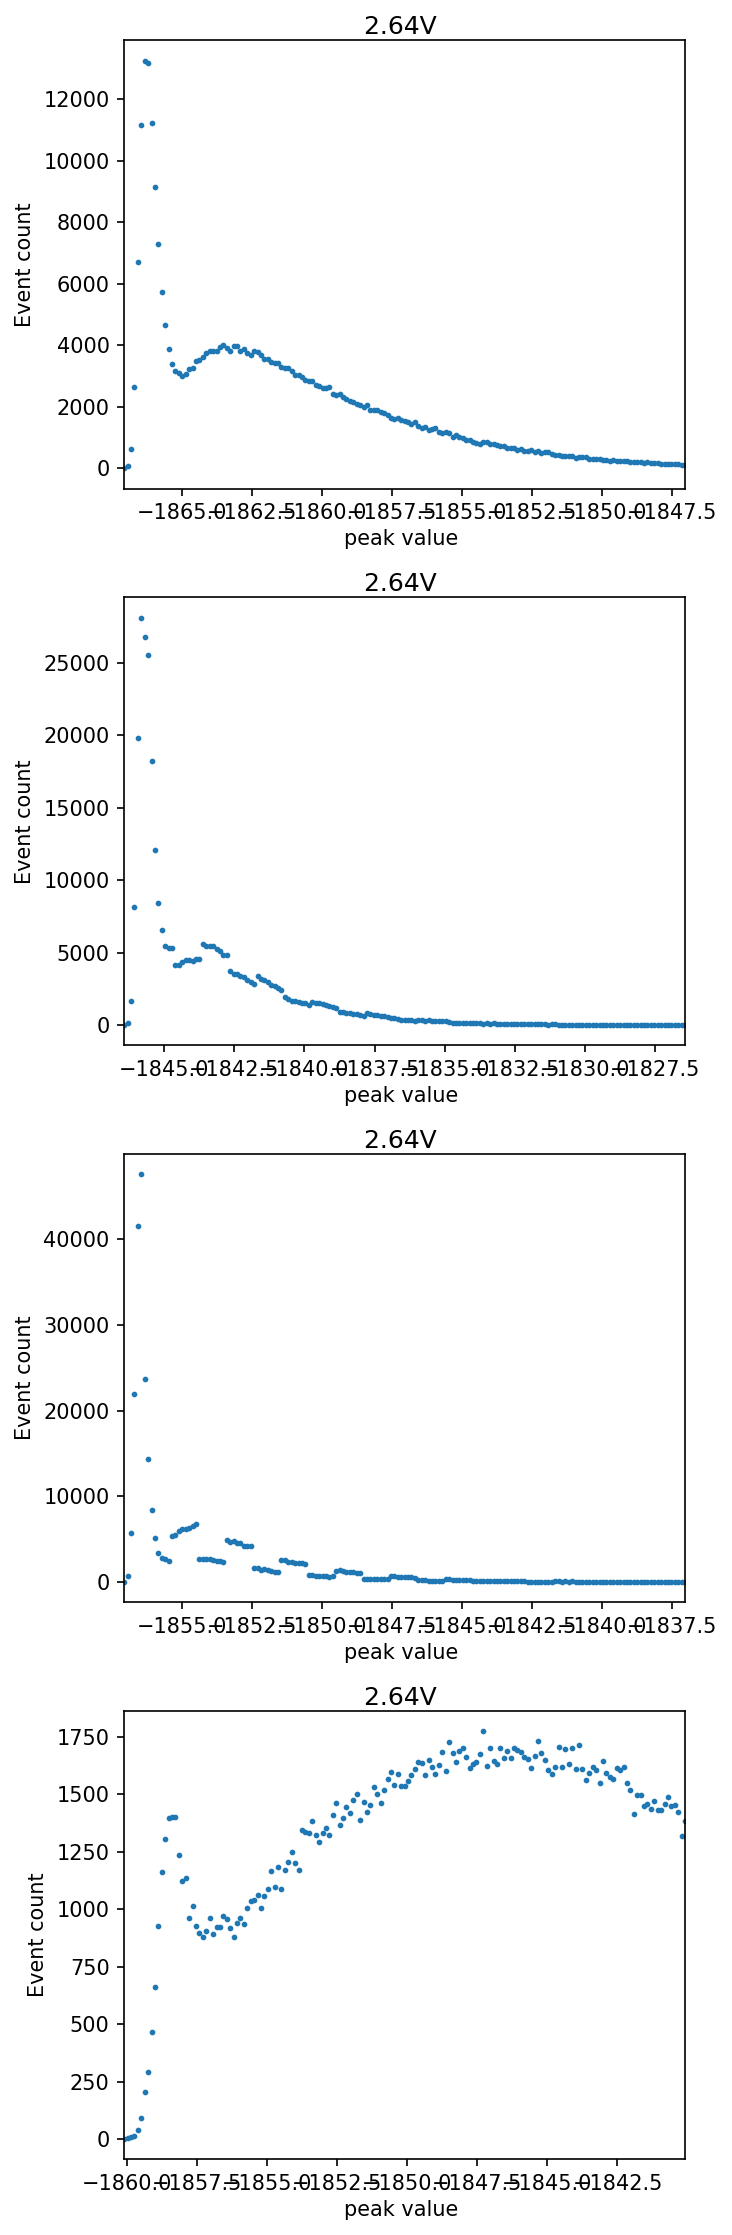

In [84]:
fig, ax = plt.subplots(4, 1, figsize=(6,15), dpi=150)
for k, d in data.items():
    # d.get_distribution()
    d.get_peak_distribution()
    plot_pcount(d, ax[k-1], f'2.64V ', xlim=(min(d.peak_dist.keys()), min(d.peak_dist.keys()) + 20))
plt.tight_layout()
plt.show()

##### Decode Raw File & Write to Processed File

In [64]:
# !!!! Execute This First !!!!!
id_range = list(range(252, 260, 2)) + list(range(260, 267))
ch_list = [1,2,3,4]
xlim_set = dict(zip(ch_list,[15, 10, 10 , 20]))

In [ ]:
# Decode and write
for i in tqdm.tqdm(id_range):
    data = analyse_raw_data(f'../../data/850/{i}_850_0710V_raw_b0_seg0.bin')
    title = f"{i}_850"
    open(f'0710/raw_{title}.txt', 'w').close()
    open(f'0710/dist_{title}.txt', 'w').close()
    open(f'0710/peak_{title}.txt', 'w').close()
    for d in data.values():
        save_raw_to_file(d,f'0710/raw_{title}.txt')
        save_dist_to_file(d,f'0710/dist_{title}.txt')
        save_peak_to_file(d,f'0710/peak_{title}.txt')

##### Get from Processed File

### Electron Count Analysis

##### Plot Distribution of election count

##### Curve Fit

##### Fit Parameter Analysis

### Peak Analysis

##### Plot Distribution of peak value

##### Curve Fit